Завдання 1. Робота з набором файлів. 
1) Сформувати в папці на диску набір із 15 зображень різних форматів, розмірів та колірних моделей. Додати туди 2-3 файли, що не є зображеннями. 
2) Створити функцію, що в якості аргумента приймає адресу папки на диску та повертає датафрейм з наступною інформацією про зображення, що знаходяться в папці:
- ім’я файлу;
- кольорову модель;
- формат;
- кількість каналів у зображенні;
- розмір файлу у мегабайтах байтах, округлених до двох знаків після коми;
- ширину картинки;
- висоту картинки;
- повний шлях до файлу;
- зменшене зображення.


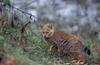
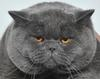
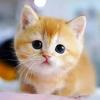
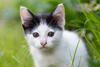
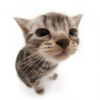
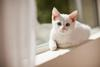
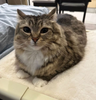
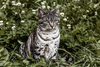
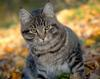
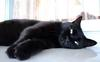
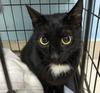
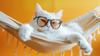
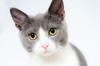
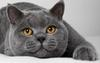
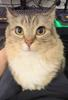

In [1]:
import os
import glob
from PIL import Image
import pandas as pd
import io
import base64
from IPython.display import HTML, display

def process_images(folder_path):
    image_data = []
    for file_path in glob.glob(os.path.join(folder_path, "*")):
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                color_model = img.mode 
                channels = len(img.getbands())
                file_name = os.path.basename(file_path)
                full_path = os.path.abspath(file_path)
                file_size_bytes = os.path.getsize(file_path)
                file_size_mb = round(file_size_bytes / (1024 * 1024), 2)
                file_format = img.format.lower() if img.format else os.path.splitext(file_path)[1][1:].lower()
                img.thumbnail((100, 100), Image.Resampling.LANCZOS)
                thumbnail_buffer = io.BytesIO()
                img.save(thumbnail_buffer, format=img.format)
                thumbnail_bytes = thumbnail_buffer.getvalue()
                thumbnail_base64 = base64.b64encode(thumbnail_bytes).decode('utf-8')
                
                image_data.append({
                    'name': file_name,
                    'color model': color_model,
                    'format': file_format.upper(),
                    'channels': channels,
                    'size': file_size_mb,
                    'width': width,
                    'height': height,
                    'full path': full_path,
                    'image': thumbnail_base64
                })
                
        except Exception as e:
            continue

    if image_data:
        df = pd.DataFrame(image_data)
        def thumbnail_html(base64_data, format_type):
            return f'<img src="data:image/{format_type.lower()};base64,{base64_data}" width="100" height="100" style="margin: 5px;">'
        df['image'] = df.apply(lambda row: thumbnail_html(row['image'], row['format']), axis=1)
        display(HTML(df.to_html(escape=False)))
    else:
        return pd.DataFrame()

process_images('C:\\Users\\zheny\\task4')

Завдання 2. Створити функцію, що в якості аргумента приймає:
- шлях до папки; 
- назва вихідного зображення; 
- кількість зображень в рядку; 
- кількість зображень в стовпчику 

і повертає зображення постера. Вважаємо, що постер є прямокутним і число картинок в постері a x b, де а – число стовпчиків, а b – число рядків.

Зауваження:
1) Створити функцію, що перетворює картинку на квадрат з максимально можливим розміром сторони (наприклад, якщо картинка розміром 800x533,то вихідний розмір повинен бути 533x533). Обрізаємо картинку з двох країв, тобто розмір розраховуємо від центру.
2) Всі картинки, з яких створено постер, повинні бути однакового розміру, nобто після обрізки необхідно змінити розмір, наприклад, на 500x500.
3) Картинки для додавання в постер обирати випадковим чином. Картинки можуть повторюватись.
4) На картинку «накласти фільтр» червоного, зеленого, синього, жовтого, пурпурного або голубого кольорів, що також обираються випадковим чином та можуть повторюватись.
5) Надати 3-4 варіанти постерів, що збережено у файлах на диску.
6) Використовувати зображення, що знаходяться в папці, що сформована в завданні 1
7) Для обробки зображень використовувати бібліотеки Pillow та/або OpenCV.

In [2]:
import random
from PIL import Image, ImageEnhance
import numpy as np

def create_poster(folder_path, output_name, cols, rows):
    image_paths = glob.glob(os.path.join(folder_path, "*"))
    valid_images = []
    
    for path in image_paths:
        try:
            with Image.open(path) as img:
                valid_images.append(path)
        except:
            continue
    
    if not valid_images:
        raise ValueError("У папці не знайдено зображень!")
    
    total_images = cols * rows
    target_size = 500 

    processed_images = []
    color_filters = {
        'red': (1.0, 0.0, 0.0),    
        'green': (0.0, 1.0, 0.0),  
        'blue': (0.0, 0.0, 1.0),   
        'yellow': (1.0, 1.0, 0.0), 
        'purple': (1.0, 0.0, 1.0), 
        'cyan': (0.0, 1.0, 1.0)   
    }
    
    for _ in range(total_images):
        img_path = random.choice(valid_images)
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            width, height = img.size
            min_side = min(width, height)
            left = (width - min_side) / 2
            top = (height - min_side) / 2
            right = (width + min_side) / 2
            bottom = (height + min_side) / 2
            img = img.crop((left, top, right, bottom))
            img = img.resize((target_size, target_size), Image.Resampling.LANCZOS)
            filter_name = random.choice(list(color_filters.keys()))
            filter_values = color_filters[filter_name]
            img_array = np.array(img)
            r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]
            img_array[:, :, 0] = r * filter_values[0]  
            img_array[:, :, 1] = g * filter_values[1]  
            img_array[:, :, 2] = b * filter_values[2]  
            img_array = np.clip(img_array, 0, 255).astype(np.uint8)
            img = Image.fromarray(img_array)
            
            processed_images.append(img)
    
    poster_width = cols * target_size
    poster_height = rows * target_size
    poster = Image.new('RGB', (poster_width, poster_height), 'white')
    
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(processed_images):
                poster.paste(processed_images[idx], (j * target_size, i * target_size))
    
    output_path = os.path.join(folder_path, f"{output_name}.png")
    poster.save(output_path, 'PNG')
    return poster

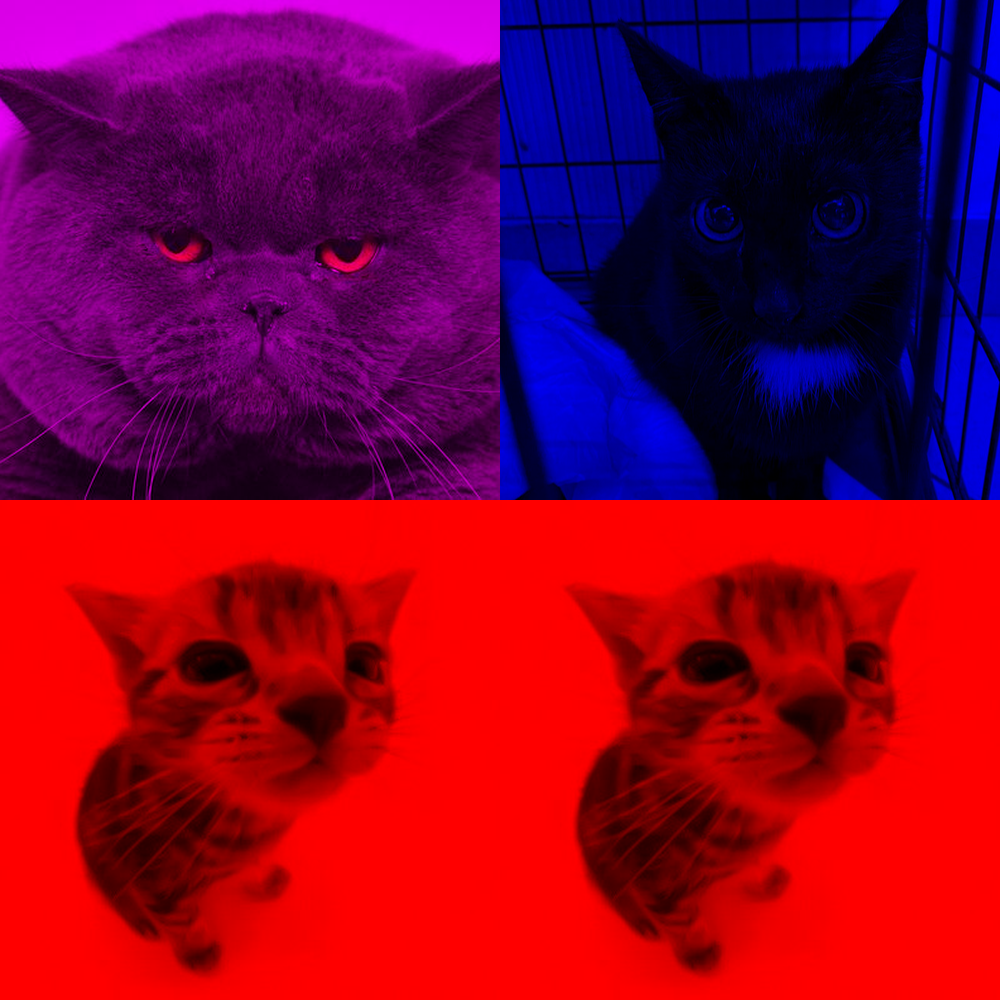

In [3]:
post1 = create_poster('C:\\Users\\zheny\\task4', 'post2x2', 2, 2)
post1

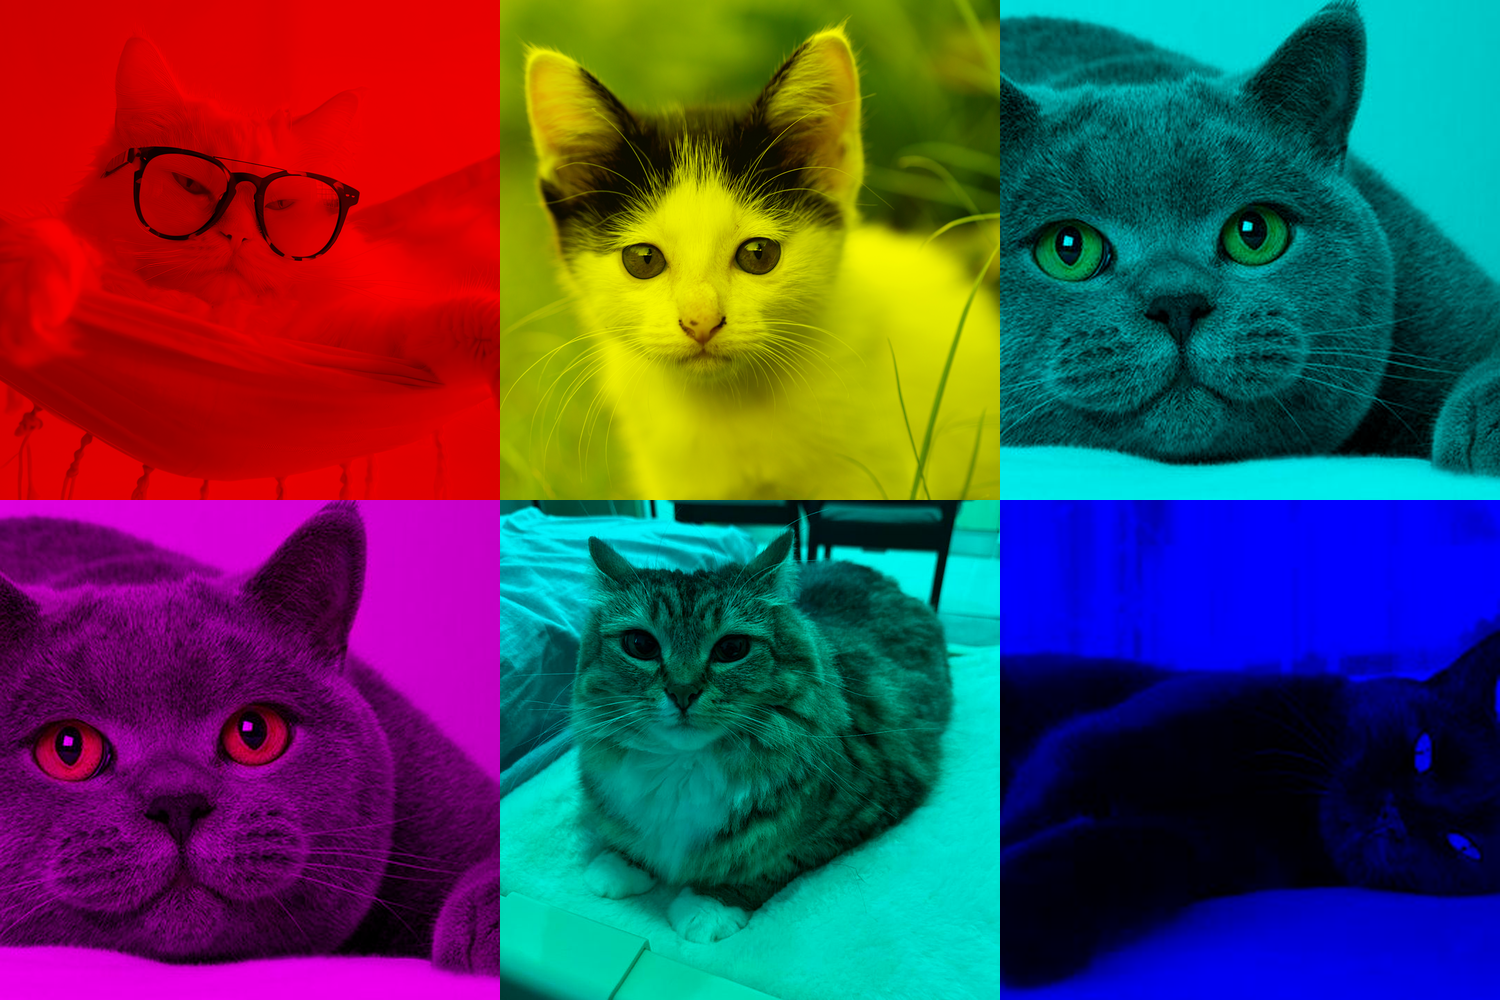

In [4]:
post2 = create_poster('C:\\Users\\zheny\\task4', 'post3x2', 3, 2)
post2

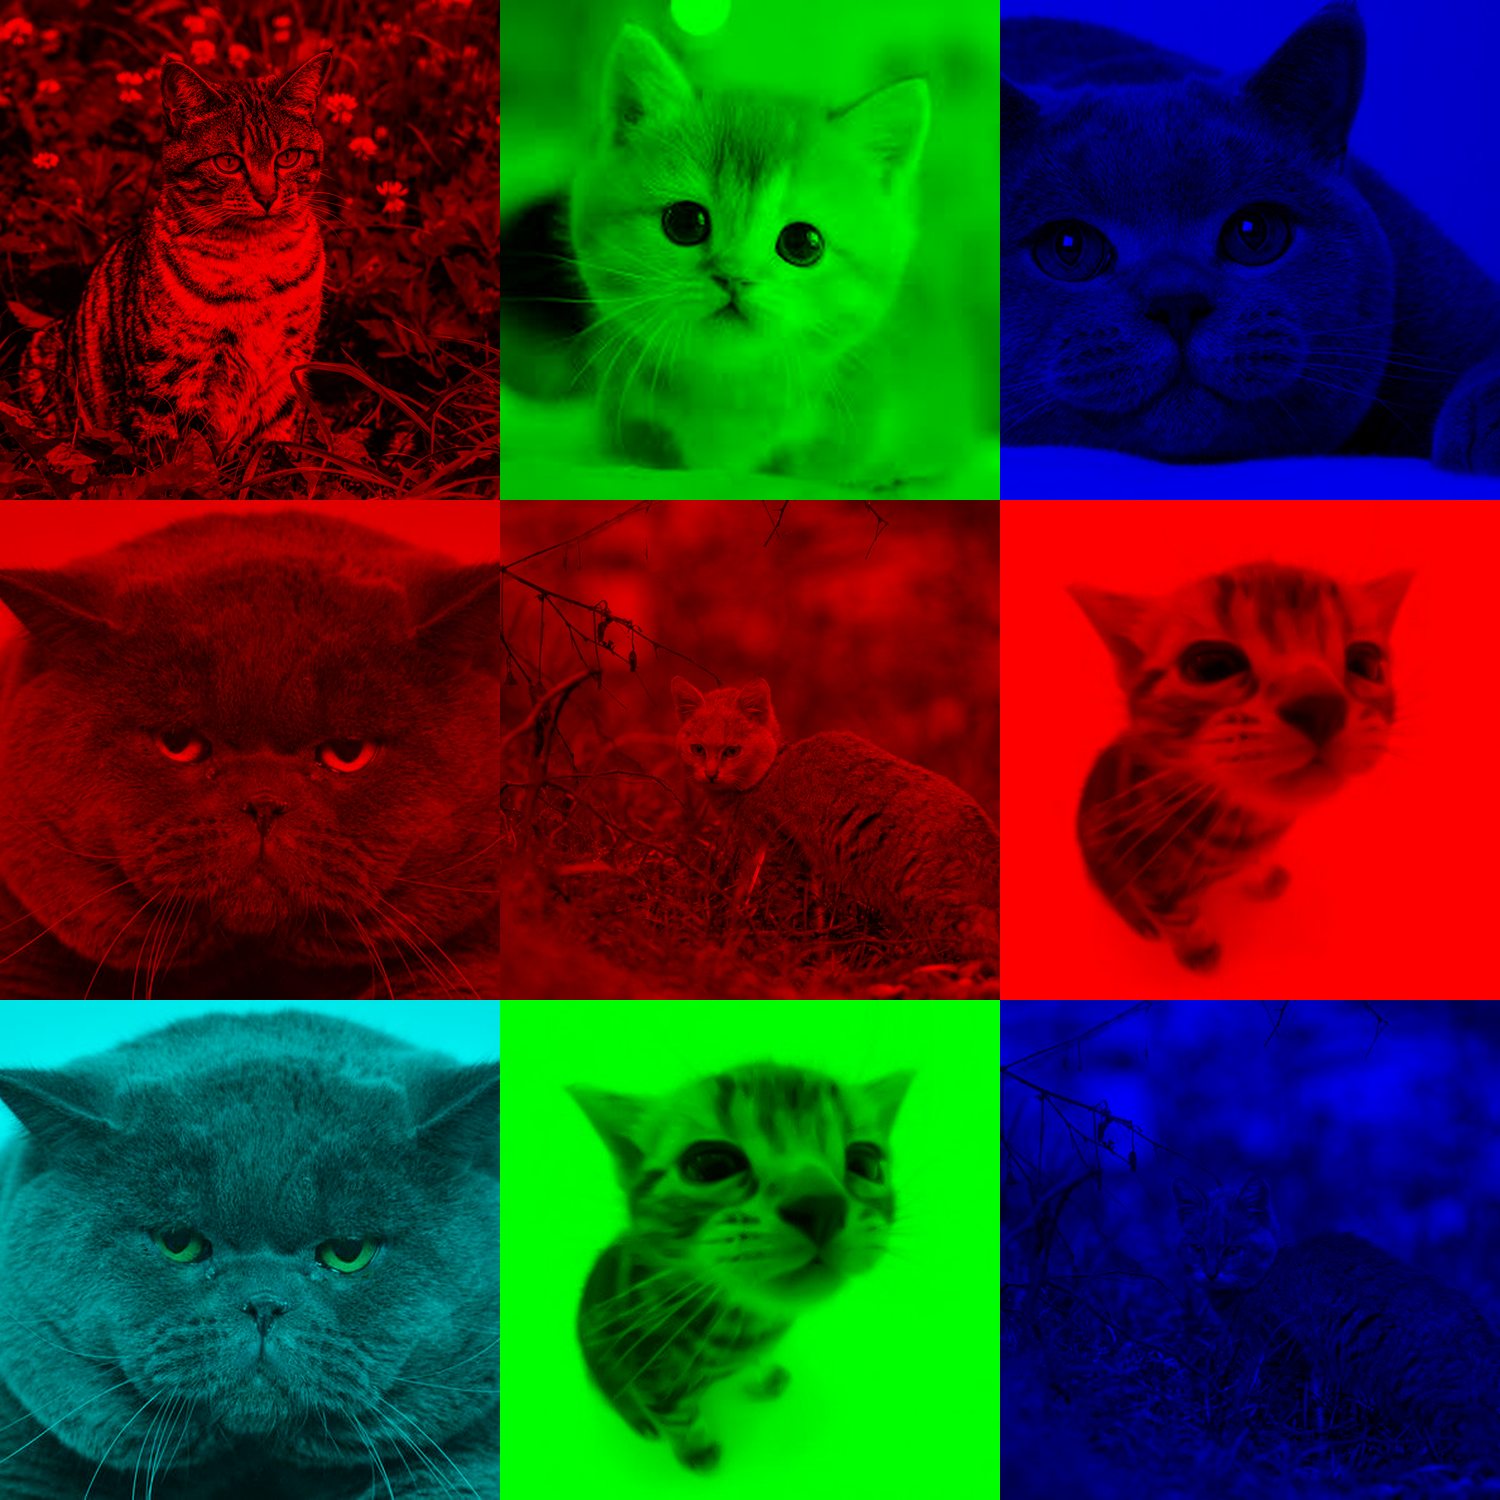

In [5]:
post3 = create_poster('C:\\Users\\zheny\\task4', 'post4x4', 3, 3)
post3